In [81]:
from Bio import AlignIO
from Bio.PDB.Polypeptide import one_to_index, index_to_one, three_to_index, index_to_three, three_to_one
from collections import Counter
%matplotlib inline

In [82]:
alignment = AlignIO.read("aligned_good_records.fasta", "fasta")

In [83]:
data = np.zeros((20, len(alignment[0])))
counts = [Counter(alignment[:, i]) for i in range(len(alignment[0]))]
for i, col in enumerate(counts):
    col_sum = sum([v for k, v in col.items() if k != "-"])
    for k, v in col.items():
        if k != "-":
            data[one_to_index(k), i] = v / col_sum
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
ax.pcolor(data, cmap='Reds')
ax.set_yticks(np.linspace(0, 19, 20) + 0.5)
ax.set_yticklabels([index_to_one(i) for i in range(20)])
ax.set_title("Residue Distribution on Light Chain MSA")
fig.tight_layout()
fig.savefig("residue_distribution_msa.png")

In [84]:
import pickle
with open("processed_records.pkl", 'rb') as fh:
    good_records = pickle.load(fh)

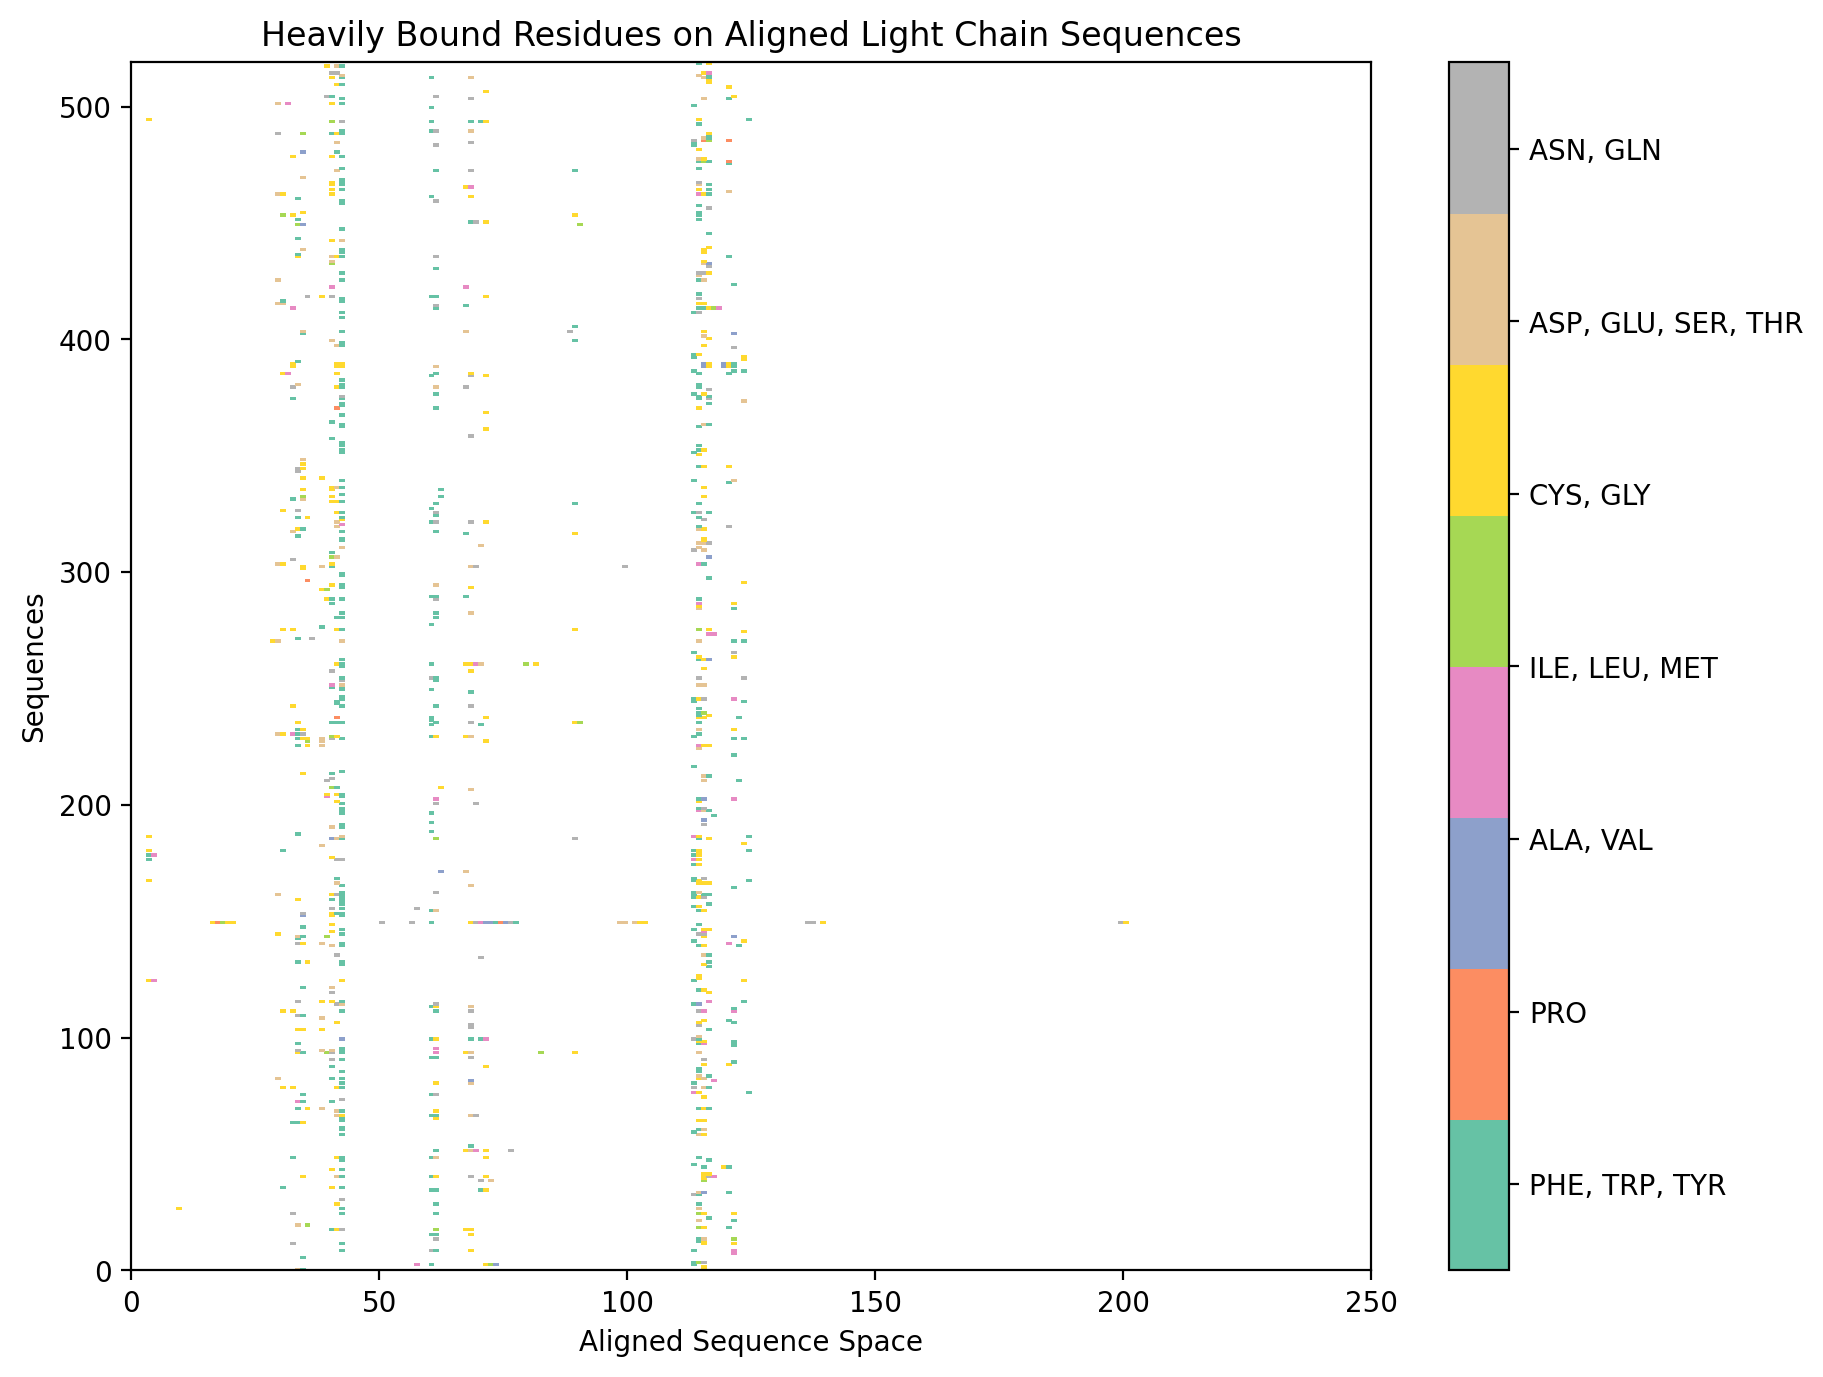

In [87]:
from collections import defaultdict
import numpy as np

aa_to_red = {
     'ALA': 2,
     'CYS': 4,
     'ASP': 5,
     'GLU': 5,
     'PHE': 0,
     'GLY': 4,
     'HIS': 7,
     'ILE': 3,
     'LYS': 7,
     'LEU': 3,
     'MET': 3,
     'ASN': 6,
     'PRO': 1,
     'GLN': 6,
     'ARG': 7,
     'SER': 5,
     'THR': 5,
     'VAL': 2,
     'TRP': 0,
     'TYR': 0
}

red_to_labels = defaultdict(list)
for k, v in aa_to_red.items():
    red_to_labels[v].append(k)


colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

highlights = []
for aligned_seq in alignment:
    pdb_id = aligned_seq.id.strip().split("|")[0]
    record = good_records[pdb_id]
    lc_resids_counts = defaultdict(int)
    lc_resid_list = record.entity_records["light"].residues
    if record.binding_interfaces is None:
        print(f"{pdb_id} does not have a computed binding interface, skipping")
        continue
    for lc, ag in record.binding_interfaces["light-antigen"].interface_pairs:
        lc_resids_counts[lc] += 1
        
    highly_bound_lc_resids = {resid for resid, count in lc_resids_counts.items() if count > 5}
        
    idx = 0
    highlight_str = []
    for char in str(aligned_seq.seq):
        if char != "-":
            resid = lc_resid_list[idx]
            assert three_to_one(resid.get_resname()) == char
            if resid in highly_bound_lc_resids:
                highlight_str.append((aa_to_red[resid.get_resname()]) / 8)
            else:
                highlight_str.append(-1)
            idx += 1
        else:
            highlight_str.append(-1)

    highlights.append(highlight_str)

highlights = np.array(highlights)
highlights = np.ma.masked_where(highlights == -1, highlights)
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
hm = ax.pcolor(highlights, cmap='Set2', norm=None)
cb = fig.colorbar(hm, ticks=np.linspace(0, 1 - 1/8, 8) + 1/16, )
cb.ax.set_yticklabels([str(", ".join(red_to_labels[i])) for i in range(8)])
ax.set_xlabel("Aligned Sequence Space")
ax.set_ylabel("Sequences")
ax.set_title("Heavily Bound Residues on Aligned Light Chain Sequences")
fig.savefig('heavily_bound_residue_alignment.png')

In [88]:
import pandas as pd

In [89]:
df = pd.read_csv('aligned_light_chain_seqs.fasta_KL.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'aligned_light_chain_seqs.fasta_KL.csv'

In [249]:
from Bio.Seq import Seq
from Bio import pairwise2

for i, row in df.iterrows():
    record = good_records[row.Id.split("|")[0]]
    anarci_seq = Seq("".join([row[f"{i}"] for i in range(1, 128) if row[f"{i}"] != "-"]))
    alignment = pairwise2.align.globalms(record.lc_seq.seq, anarci_seq, 2, -5, -5, -0, one_alignment_only=True)[0]
    post_alignment = alignment.seqB.strip("-")
    # TODO: build index map
    if "-" in post_alignment:
        print(f"Inconclusive alignment of ANARCI back to PDB light chain: {row.Id.split('|')[0]}")

Inconclusive alignment of ANARCI back to PDB light chain: 1jrh
Inconclusive alignment of ANARCI back to PDB light chain: 1nfd
Inconclusive alignment of ANARCI back to PDB light chain: 5vgj
Inconclusive alignment of ANARCI back to PDB light chain: 5w1m
Inconclusive alignment of ANARCI back to PDB light chain: 6mto
Inconclusive alignment of ANARCI back to PDB light chain: 6nmt
Inconclusive alignment of ANARCI back to PDB light chain: 6nmv
Inconclusive alignment of ANARCI back to PDB light chain: 7c6a


In [190]:
# from ablc.StructSeqRecord import *
# from Bio.SeqIO import SeqRecord
# from Bio.Seq import Seq
# records = []
# for rec in good_records.values():
#     try:
#         seq = get_sequence_from_pdb(rec.pdb_id, keyword="antigen", use_strand_id_backup=True, strands=rec.lc_chain_names)
#         records.append(
#             SeqRecord(Seq(seq), id=f"{rec.pdb_id}|antigen|{len(seq)}")
#         )
#     except LookupError as e:
#         print(f"Could not find antigen sequence for {rec.pdb_id}")

# from Bio import SeqIO

# with open("good_antigens.fasta", 'w') as fh:
#     SeqIO.write(records, fh, format='fasta')

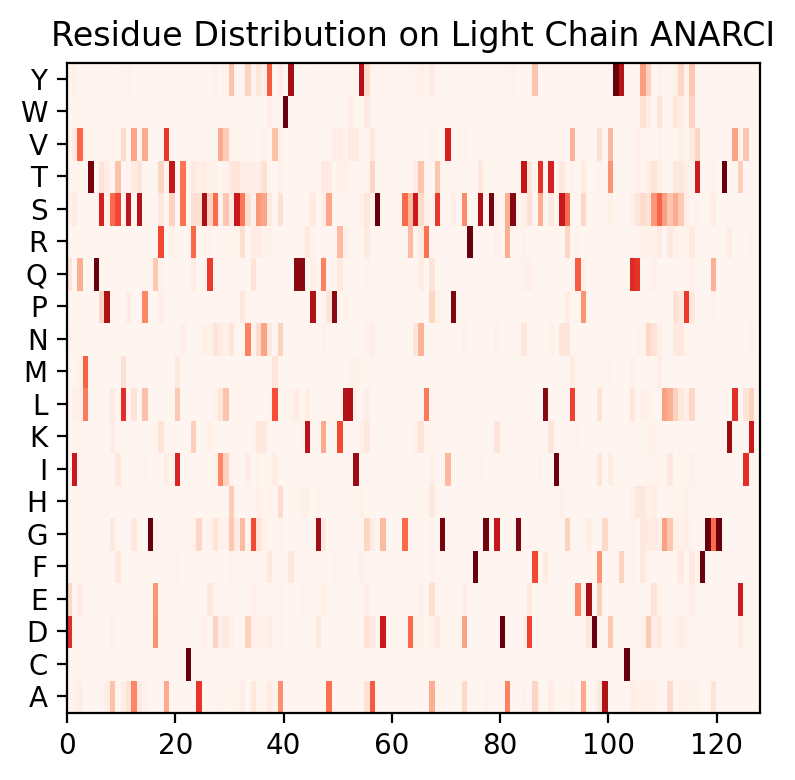

In [385]:
counts_anarci = [Counter(df[f"{i}"]) for i in range(1, 128)]
data_anarci = np.zeros((20, 128))
for i, col in enumerate(counts_anarci):
    col_sum = sum([v for k, v in col.items() if k != "-"])
    for k, v in col.items():
        if k != "-":
            data_anarci[one_to_index(k), i] = v / col_sum
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
ax.pcolor(data_anarci, cmap='Reds')
ax.set_yticks(np.linspace(0, 19, 20) + 0.5)
ax.set_yticklabels([index_to_one(i) for i in range(20)])
ax.set_title("Residue Distribution on Light Chain ANARCI")
fig.tight_layout()
fig.savefig("residue_distribution_anarci.png")

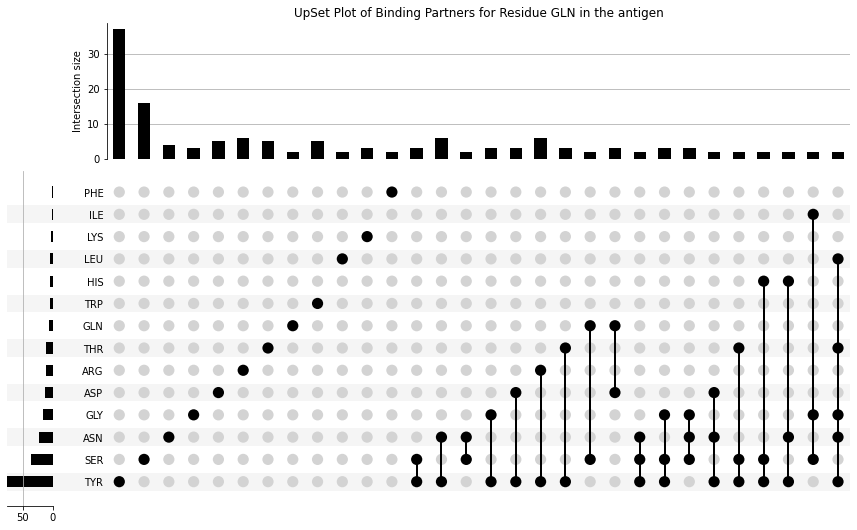

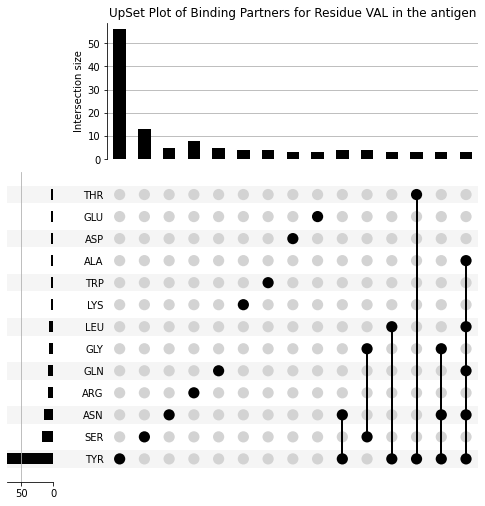

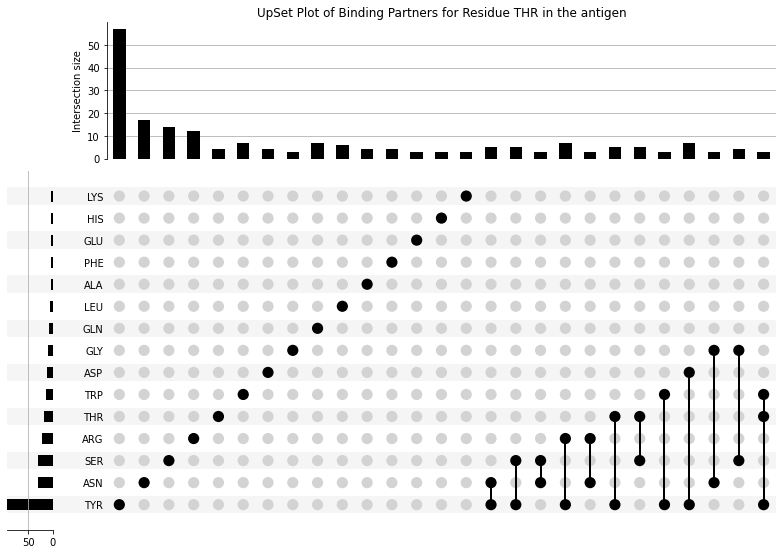

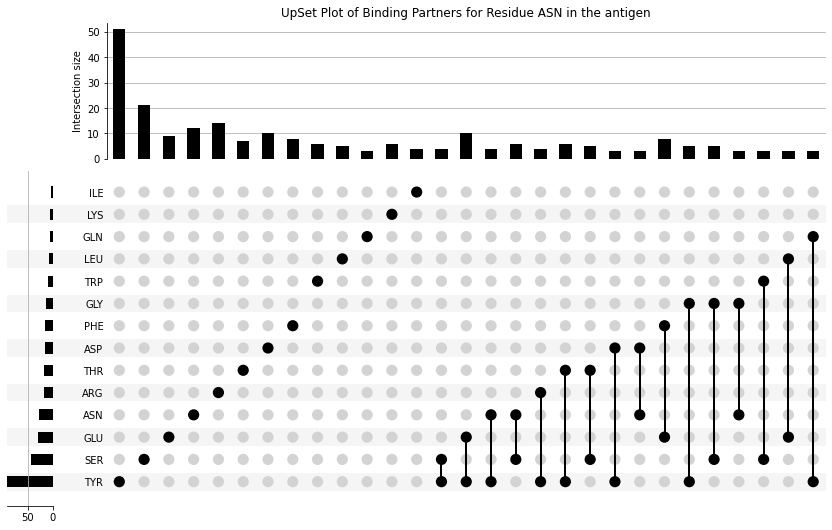

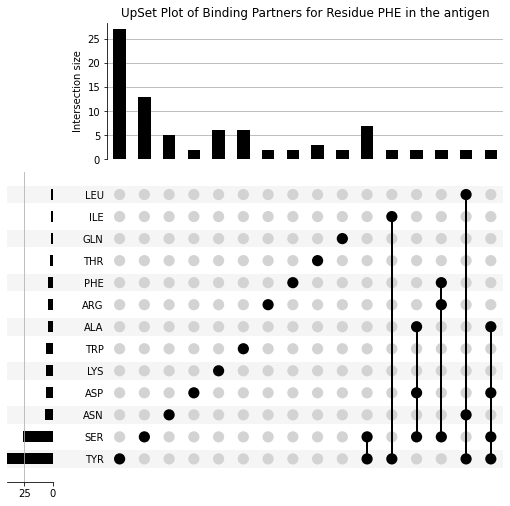

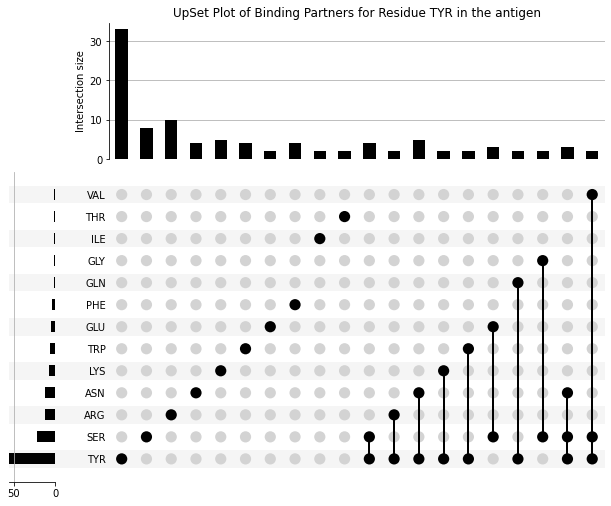

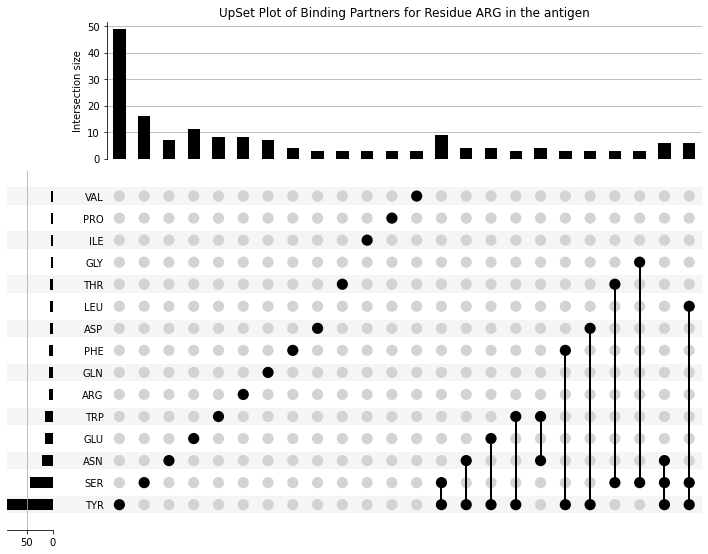

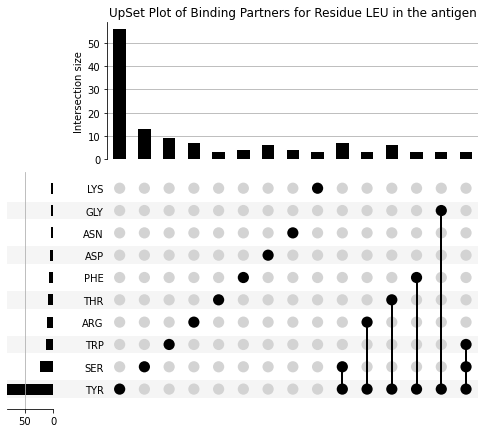

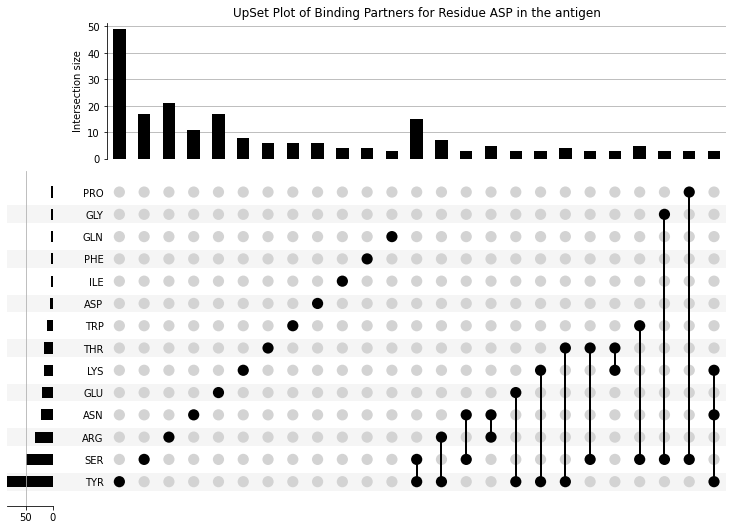

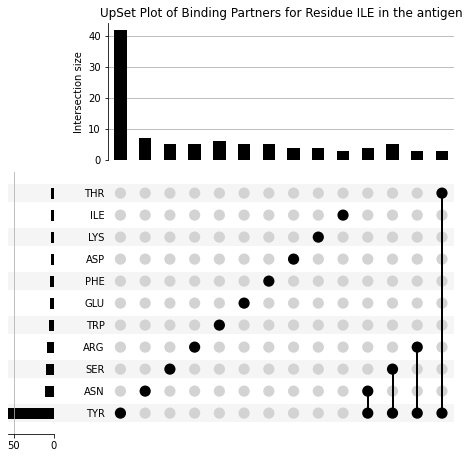

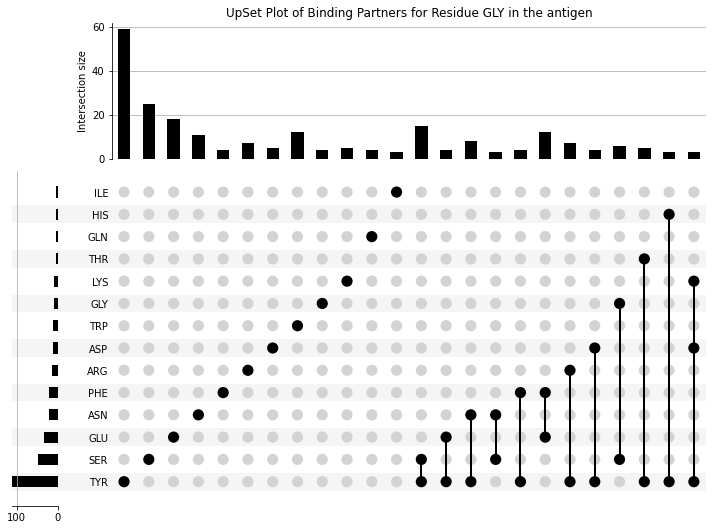

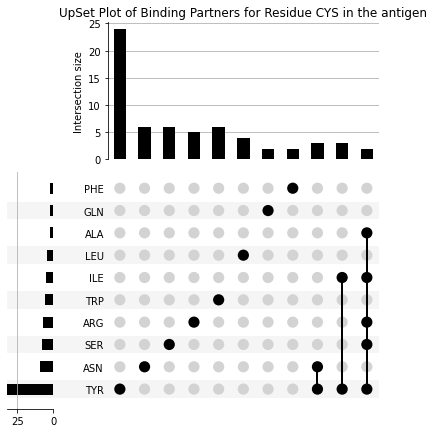

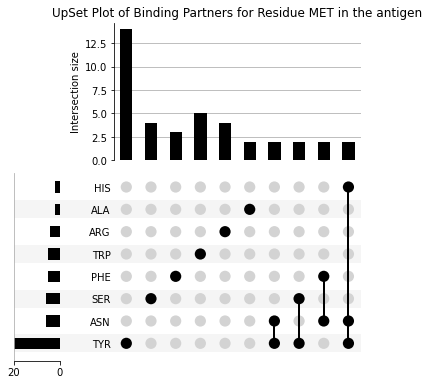

In [294]:
from collections import defaultdict

global_binding_partners = defaultdict(lambda: defaultdict(int))

for record in good_records.values():
    
    local_binding_partners = defaultdict(set)
    
    for lc, ag in record.binding_interface:
        if not (is_aa(lc.get_resname(), standard=True) and is_aa(ag.get_resname(), standard=True)):
            continue
        local_binding_partners[ag].add(lc.get_resname())
    
    for res, bp_set in local_binding_partners.items():
        global_binding_partners[res.get_resname()][frozenset(bp_set)] += 1

from upsetplot import from_memberships
from upsetplot import plot
from Bio.PDB.Polypeptide import is_aa

def get_data(s, drop_low=False):
    keys = np.array(list(global_binding_partners[s].keys()))
    vals = np.array(list(global_binding_partners[s].values()))
    if drop_low:
        mask = np.where((vals > max(vals) * 0.05) & (vals > 1))[0]
        keys = keys[mask]
        vals = vals[mask]
    return keys, vals

for key in global_binding_partners.keys():
    
    if not is_aa(key, standard=True):
        continue
    
    data = get_data(key, drop_low=True)
    if len(data[0]) < 2:
        continue
    data = from_memberships(*data)
    plot(data)
    plt.title(f"UpSet Plot of Binding Partners for Residue {key} in the antigen")
    plt.show()
    plt.savefig("")

In [381]:
super_set = dict()
idx_to_name = dict()

counter = 0
for ag, lc_set in global_binding_partners.items():
    for s in lc_set.keys():
        if s not in super_set:
            super_set[s] = counter
            idx_to_name[counter] = "{" + ", ".join(r for r in s) + "}"
            counter += 1
        

data = np.zeros((len(list(global_binding_partners.keys())), len(super_set)))
for i, (ag, lc_set) in enumerate(global_binding_partners.items()):
    for s in lc_set.keys():
        data[i, super_set[s]] += lc_set[s]

from matplotlib.patches import Rectangle

row_sums = data.sum(axis=1)
data = data / row_sums[:, np.newaxis]
mask = np.where(data.max(0) > 0.025)[0]
data = data[:, mask]

data = np.divide(np.ones_like(data), data, out=np.full_like(data, 20), where=data!=0)
data = data.clip(max=20)

heavy_hitters = np.where(data < 13)

fig, ax = plt.subplots(figsize=(5, 4), dpi=200)
hm = ax.pcolor(data, norm=None, cmap='viridis_r')
cb = fig.colorbar(hm, label="Pseudoperplexity")

for x, y in zip(*heavy_hitters):
    ax.add_patch(Rectangle((y, x), 1, 1, fill=False, edgecolor='r', lw=1))

ax.set_yticks(np.linspace(0, 19, 20) + 0.5)
ax.set_yticklabels([index_to_one(i) for i in range(20)])
ax.set_ylabel("Antigen Residue")
ax.set_xlabel("Light Chain Binding Partner Set")
ax.set_xticks(np.linspace(0, len(mask) - 1, len(mask)) + 0.5)
ax.set_xticklabels([idx_to_name[i] for i in mask], rotation=90, fontsize=7)
ax.set_title("Binding partner sets conditioned on antigen residue")
fig.tight_layout()
fig.savefig("binding_partner_sets.png")

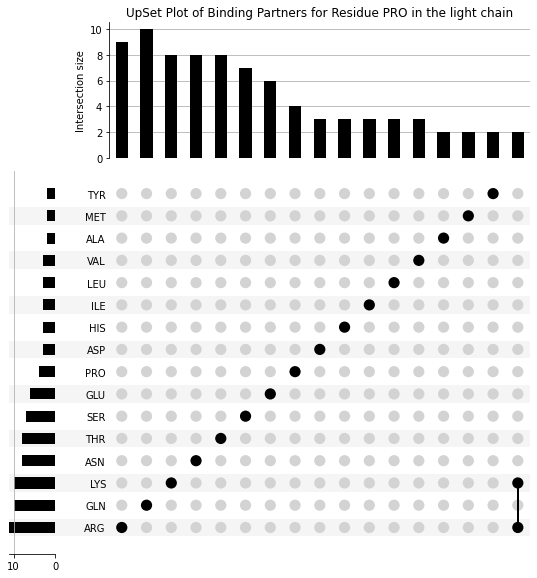

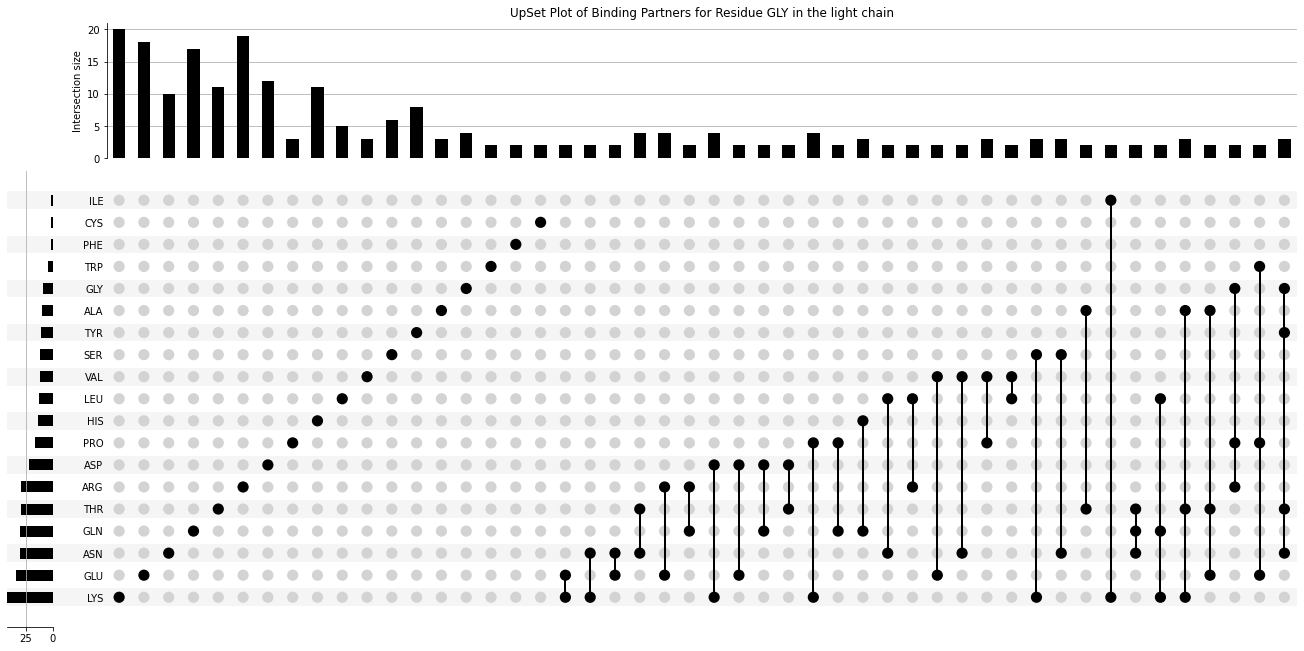

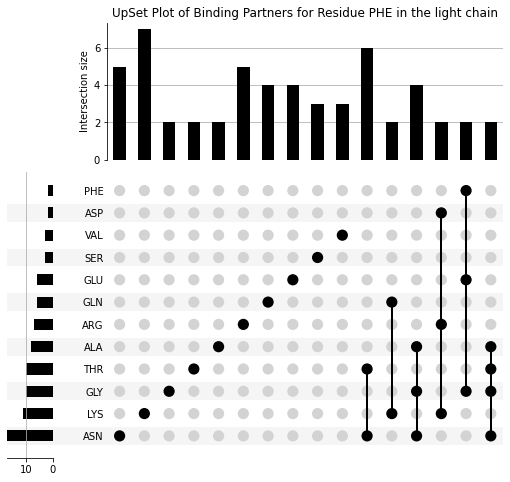

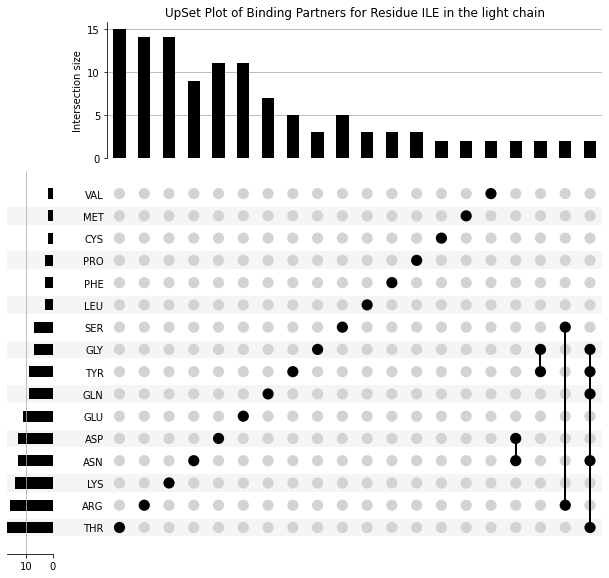

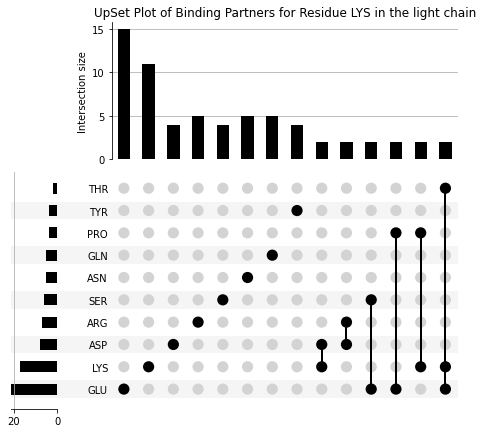

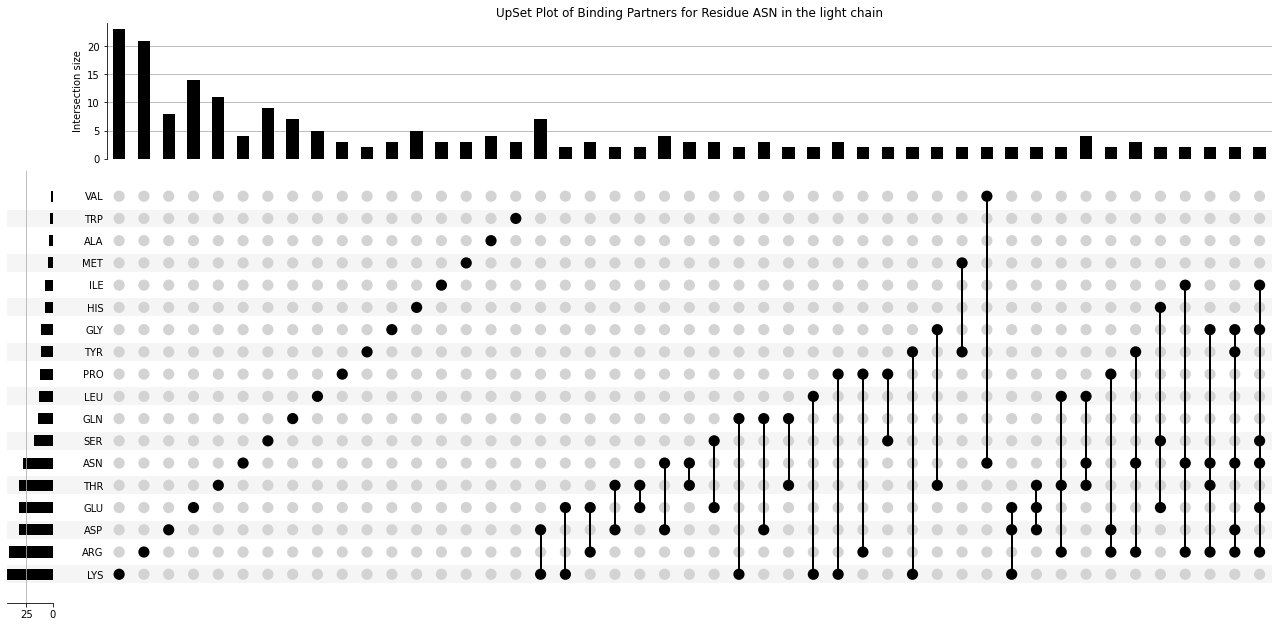

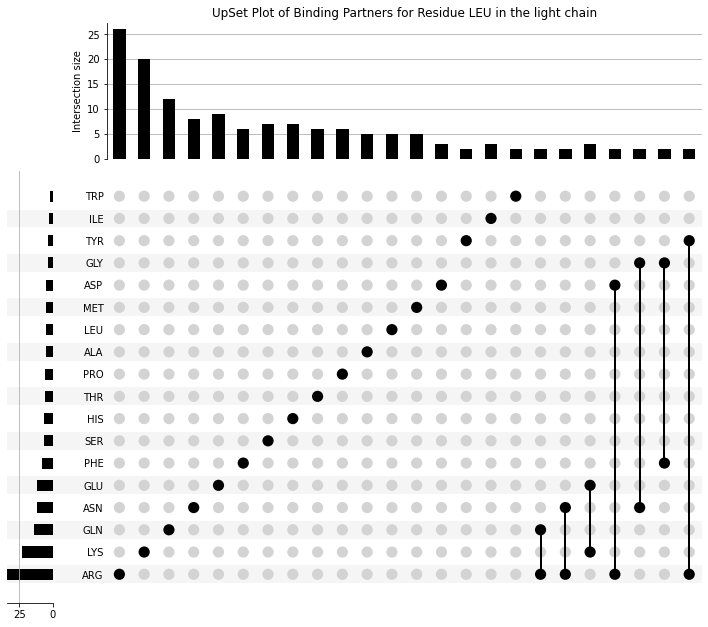

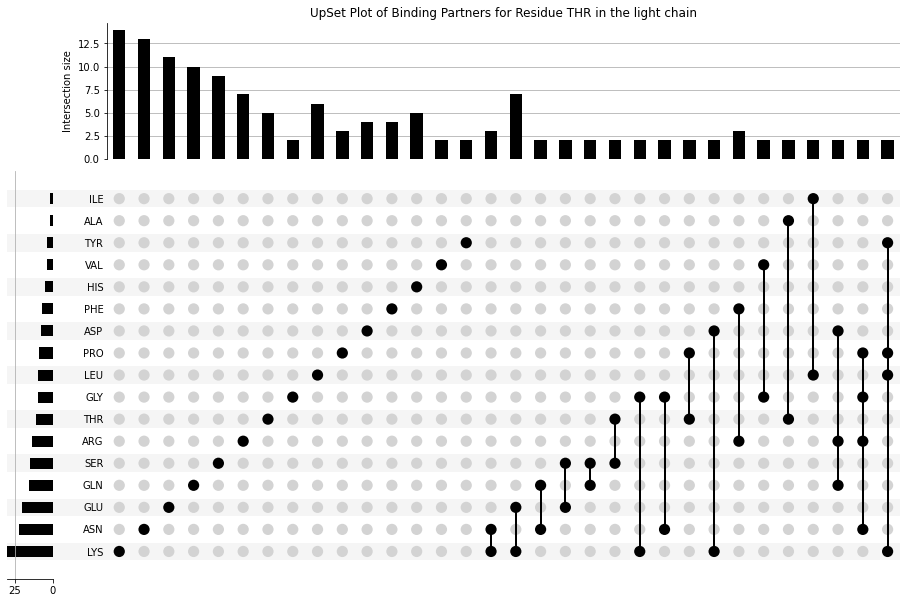

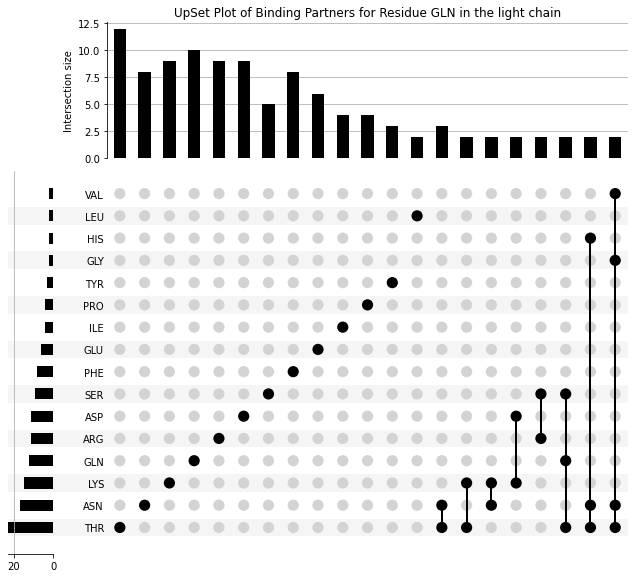

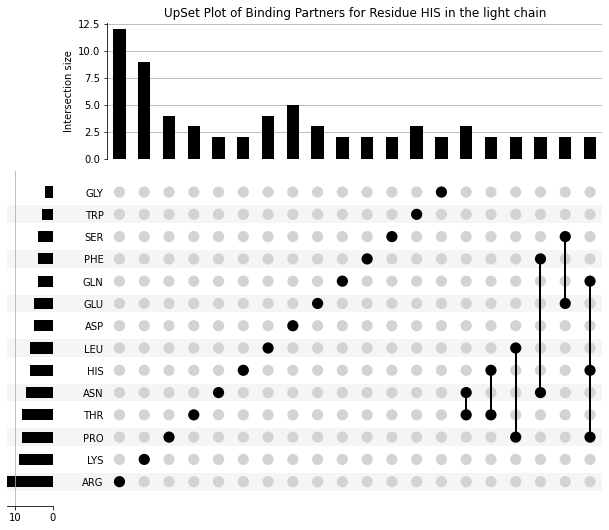

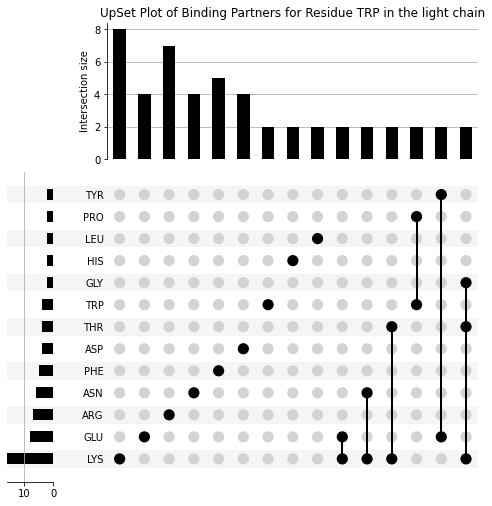

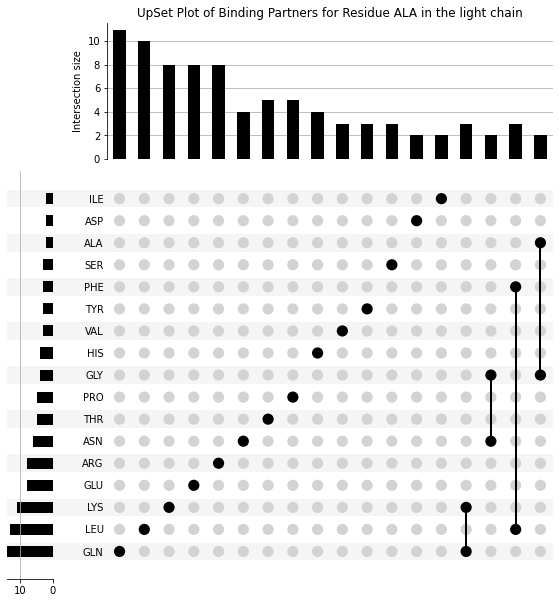

In [388]:
from collections import defaultdict

global_binding_partners = defaultdict(lambda: defaultdict(int))

for record in good_records.values():
    
    local_binding_partners = defaultdict(set)
    
    for lc, ag in record.binding_interface:
        if not (is_aa(lc.get_resname(), standard=True) and is_aa(ag.get_resname(), standard=True)):
            continue
        local_binding_partners[lc].add(ag.get_resname())
    
    for res, bp_set in local_binding_partners.items():
        global_binding_partners[res.get_resname()][frozenset(bp_set)] += 1

from upsetplot import from_memberships
from upsetplot import plot
from Bio.PDB.Polypeptide import is_aa

def get_data(s, drop_low=False):
    keys = np.array(list(global_binding_partners[s].keys()))
    vals = np.array(list(global_binding_partners[s].values()))
    if drop_low:
        mask = np.where((vals > max(vals) * 0.05) & (vals > 1))[0]
        keys = keys[mask]
        vals = vals[mask]
    return keys, vals

for key in global_binding_partners.keys():
    
    if not is_aa(key, standard=True):
        continue
    
    data = get_data(key, drop_low=True)
    if len(data[0]) < 2:
        continue
    data = from_memberships(*data)
    plot(data)
    plt.title(f"UpSet Plot of Binding Partners for Residue {key} in the light chain")
    plt.show()

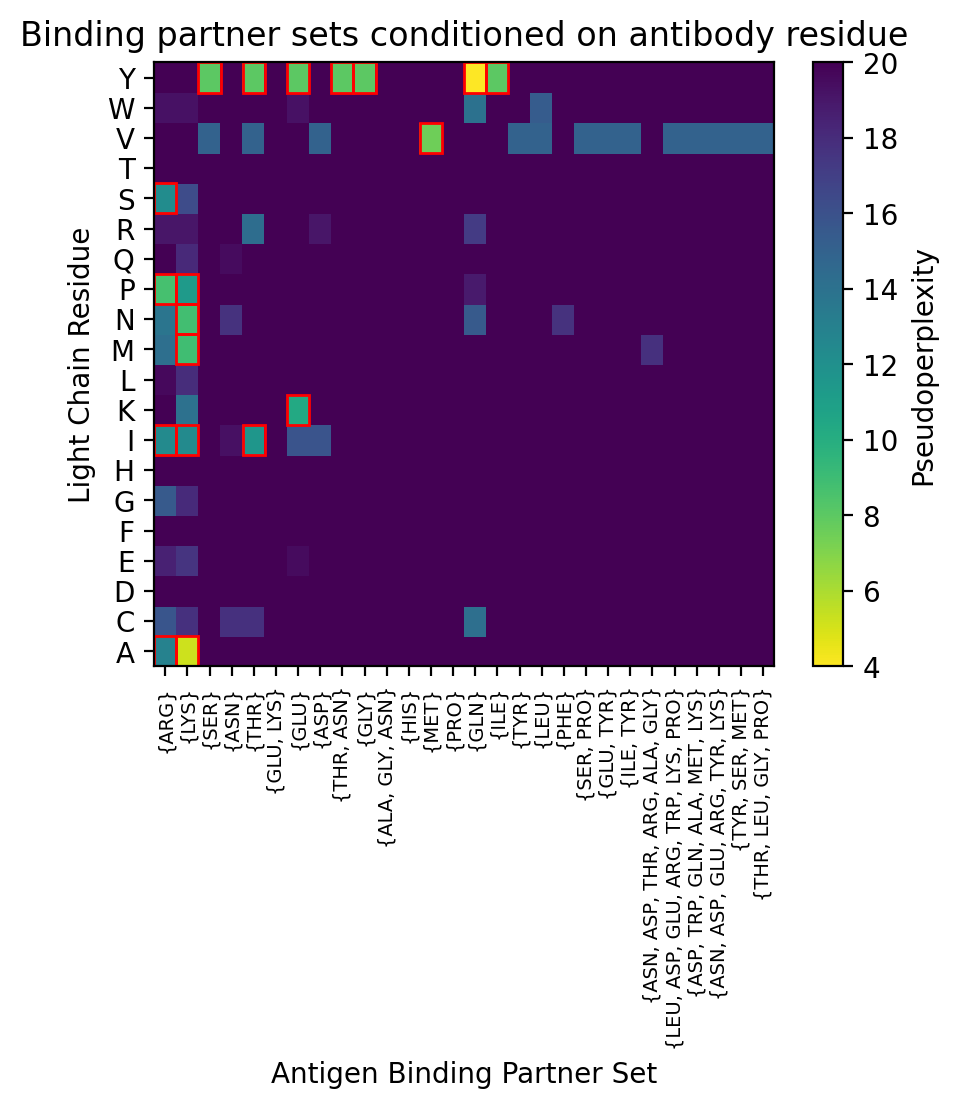

In [390]:
super_set = dict()
idx_to_name = dict()

counter = 0
for ag, lc_set in global_binding_partners.items():
    for s in lc_set.keys():
        if s not in super_set:
            super_set[s] = counter
            idx_to_name[counter] = "{" + ", ".join(r for r in s) + "}"
            counter += 1
        

data = np.zeros((len(list(global_binding_partners.keys())), len(super_set)))
for i, (ag, lc_set) in enumerate(global_binding_partners.items()):
    for s in lc_set.keys():
        data[i, super_set[s]] += lc_set[s]

from matplotlib.patches import Rectangle

row_sums = data.sum(axis=1)
data = data / row_sums[:, np.newaxis]
mask = np.where(data.max(0) > 0.025)[0]
data = data[:, mask]

data = np.divide(np.ones_like(data), data, out=np.full_like(data, 20), where=data!=0)
data = data.clip(max=20)

heavy_hitters = np.where(data < 13)

fig, ax = plt.subplots(figsize=(5, 4), dpi=200)
hm = ax.pcolor(data, norm=None, cmap='viridis_r')
cb = fig.colorbar(hm, label="Pseudoperplexity")

for x, y in zip(*heavy_hitters):
    ax.add_patch(Rectangle((y, x), 1, 1, fill=False, edgecolor='r', lw=1))

ax.set_yticks(np.linspace(0, 19, 20) + 0.5)
ax.set_yticklabels([index_to_one(i) for i in range(20)])
ax.set_ylabel("Light Chain Residue")
ax.set_xlabel("Antigen Binding Partner Set")
ax.set_xticks(np.linspace(0, len(mask) - 1, len(mask)) + 0.5)
ax.set_xticklabels([idx_to_name[i] for i in mask], rotation=90, fontsize=7)
ax.set_title("Binding partner sets conditioned on antibody residue")
fig.savefig("binding_partner_sets_ab.png")

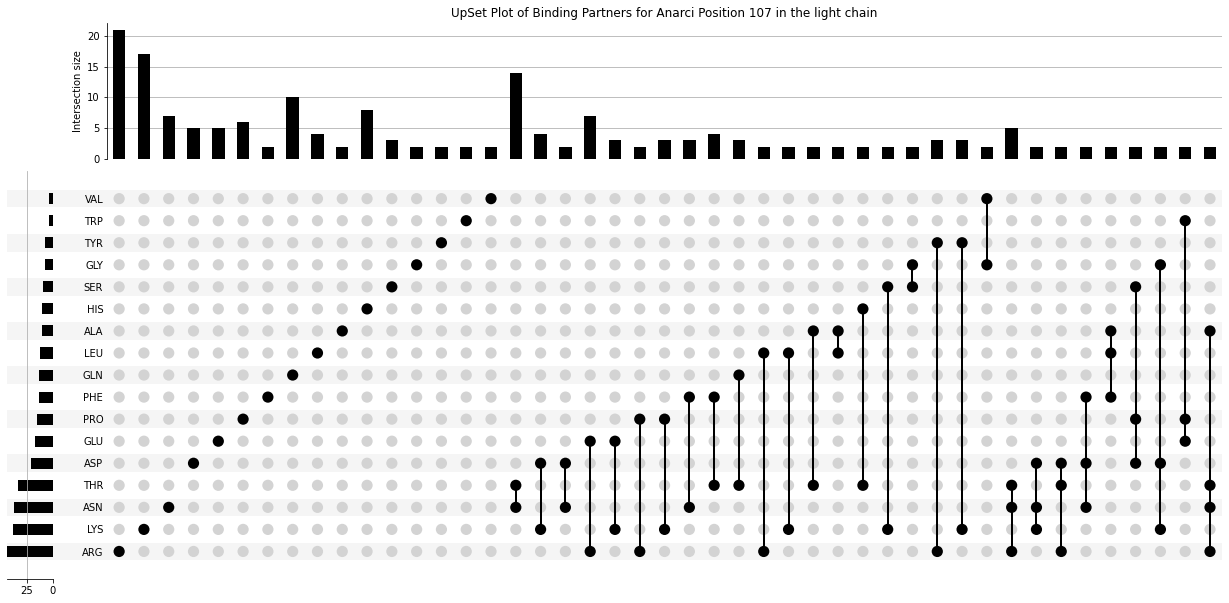

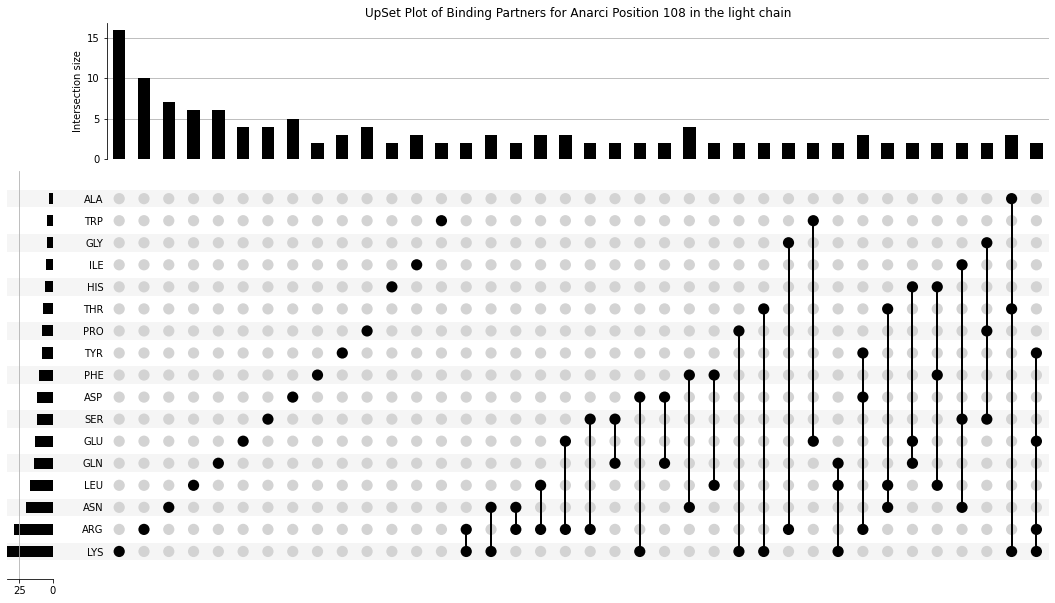

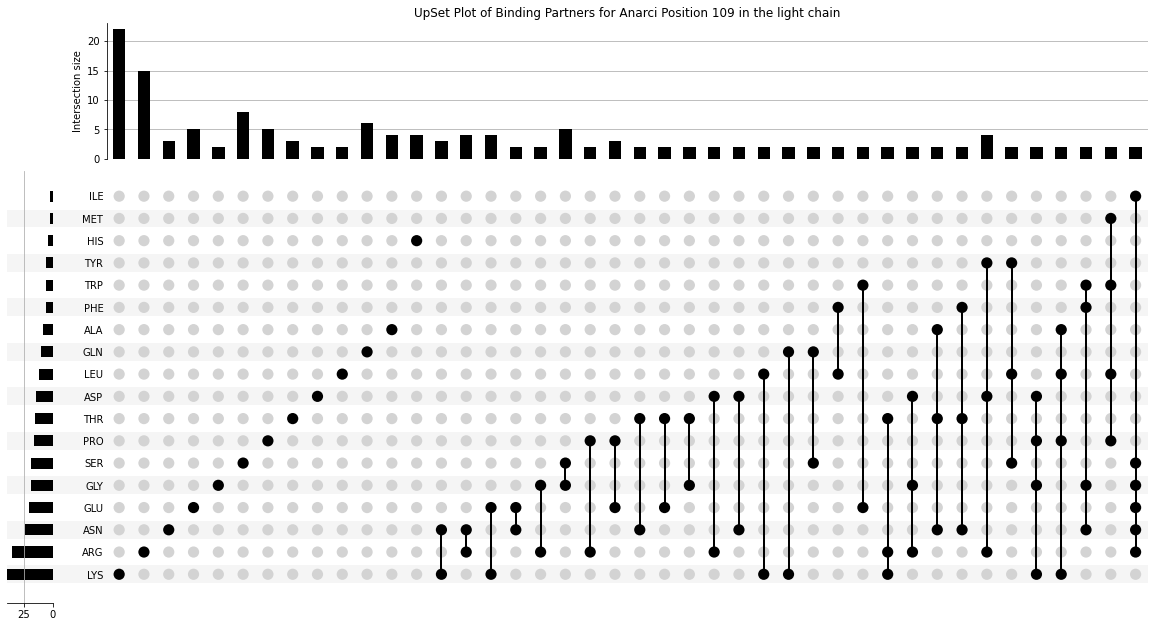

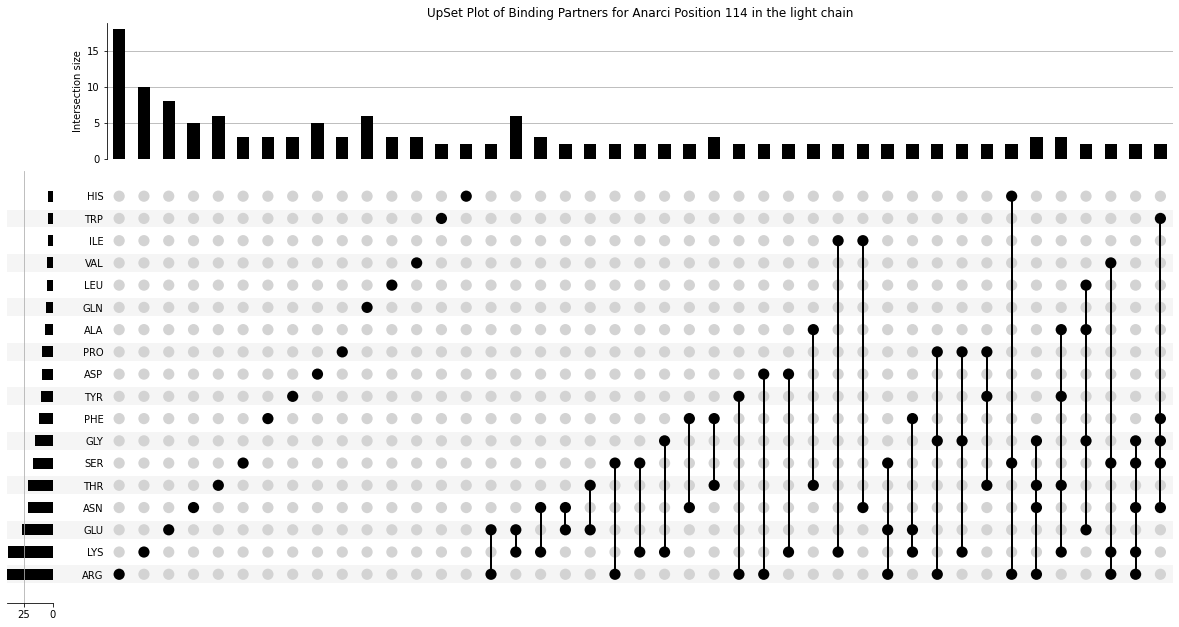

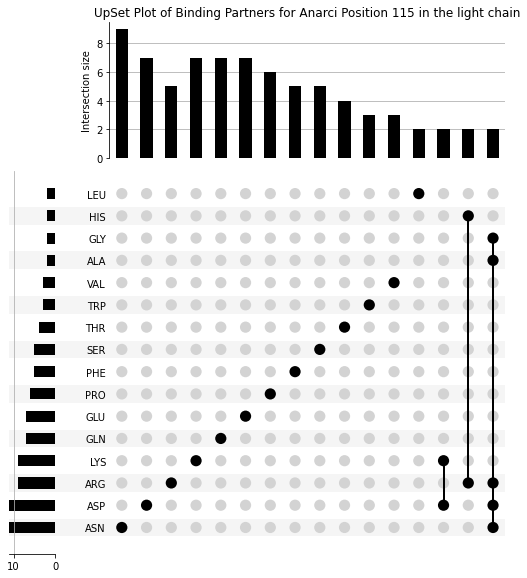

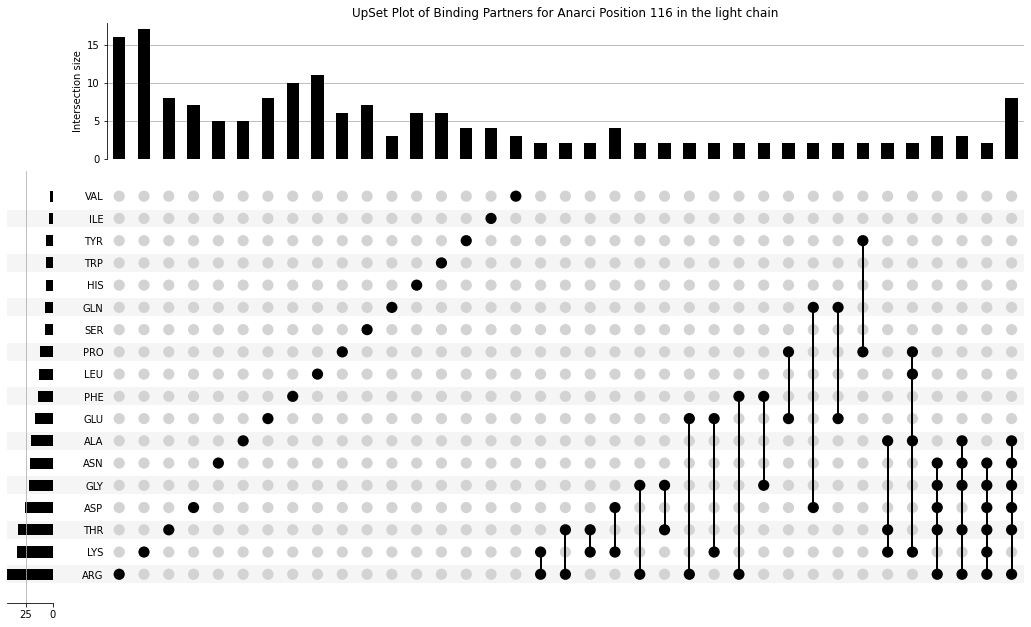

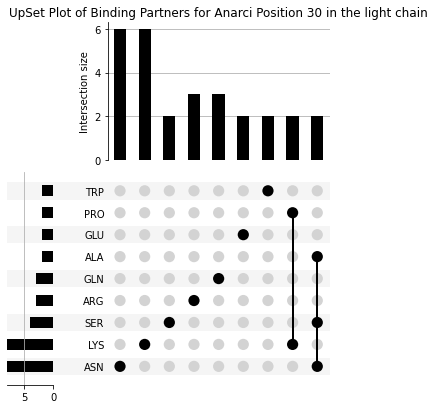

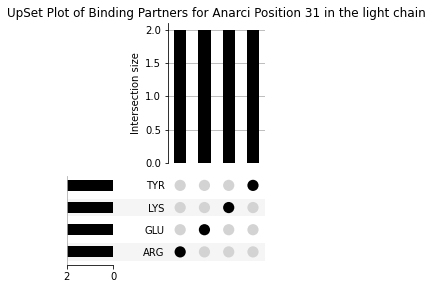

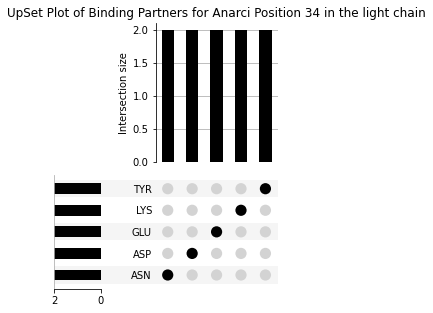

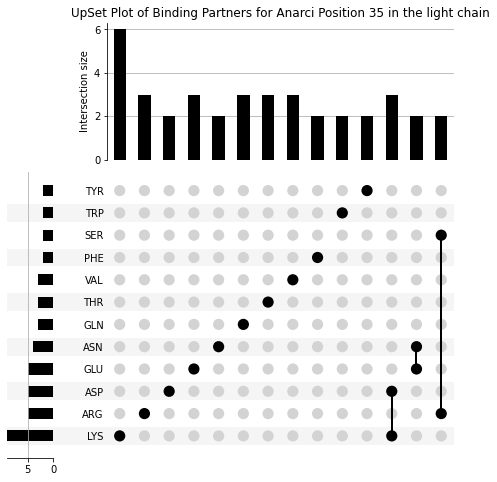

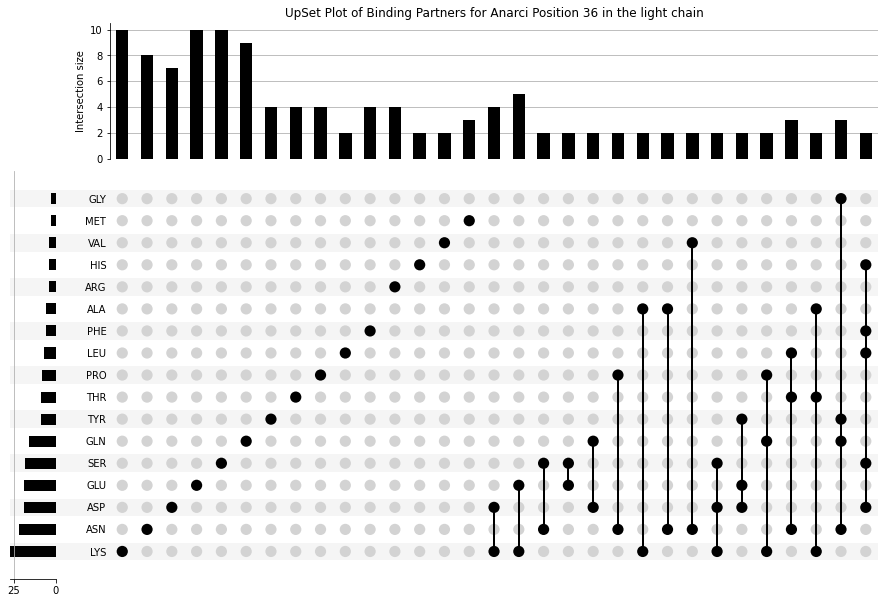

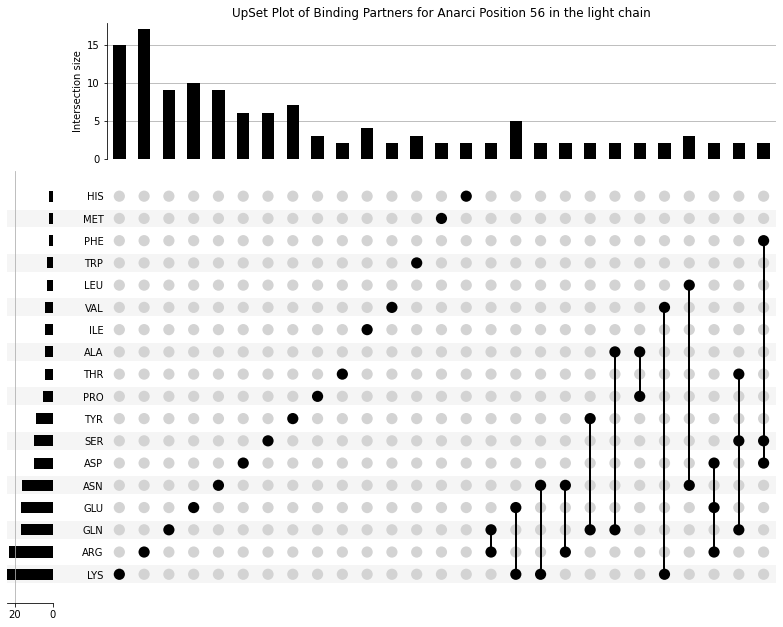

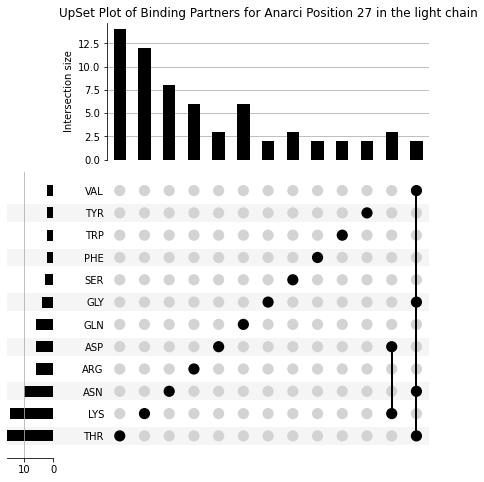

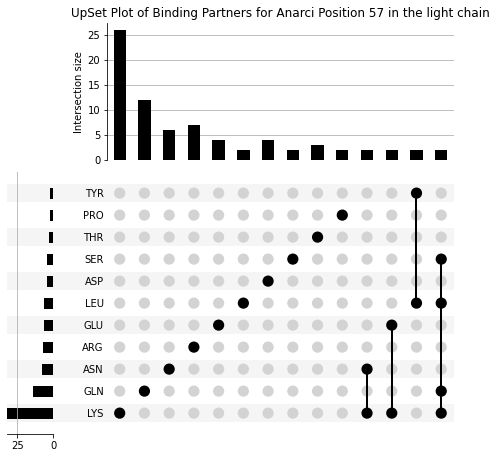

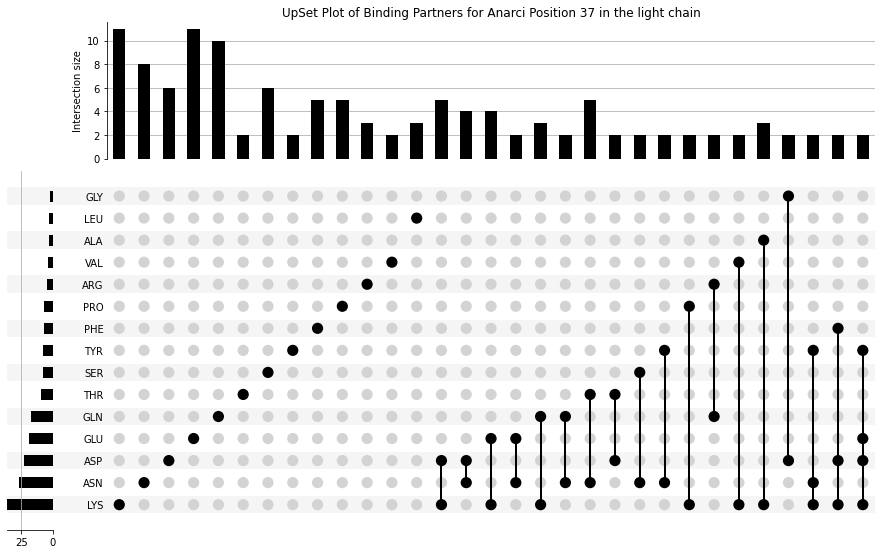

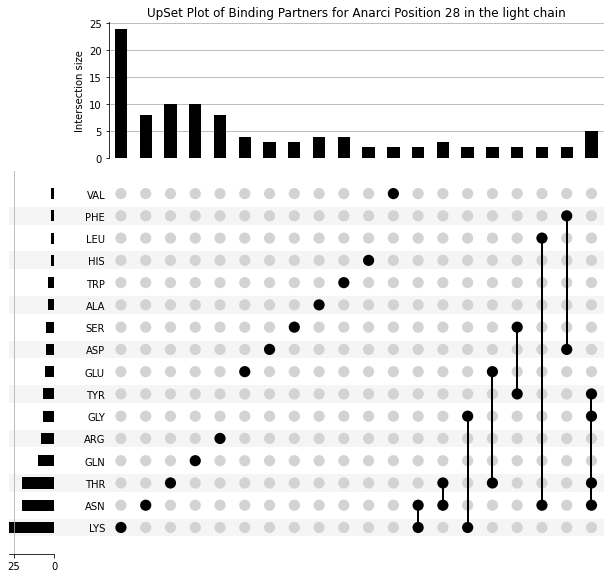

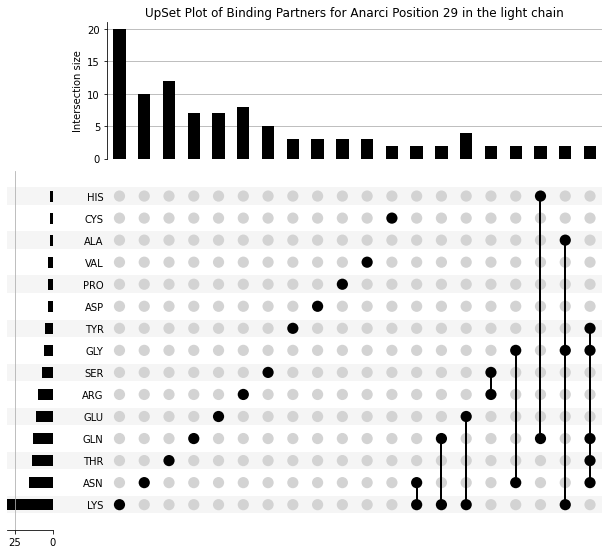

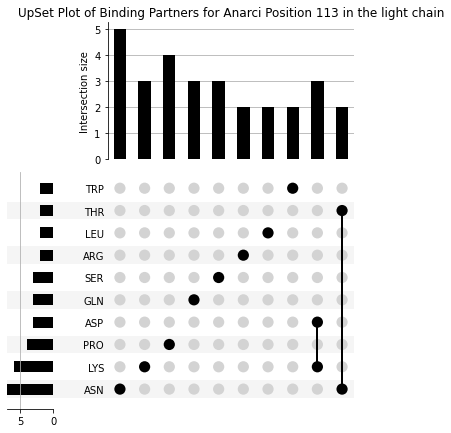

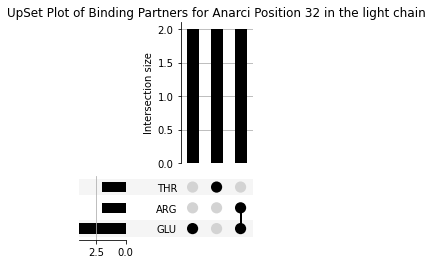

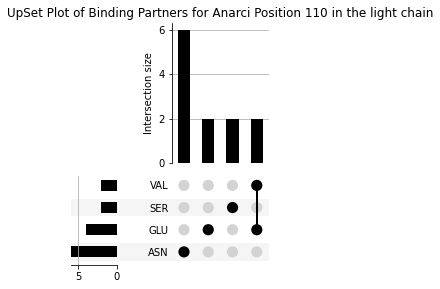

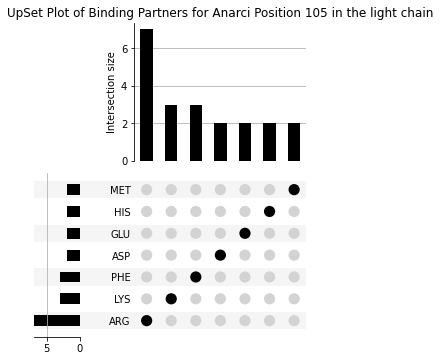

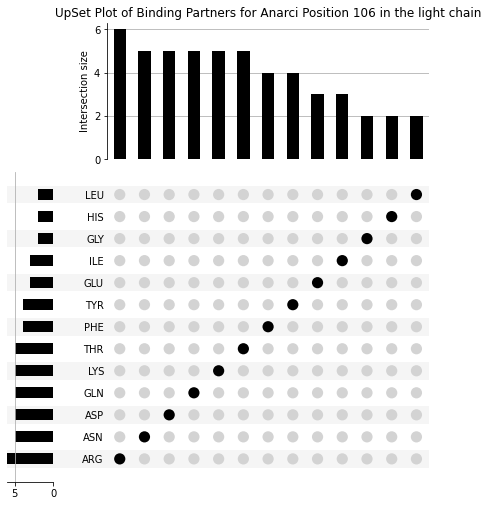

In [112]:
from collections import defaultdict
from Bio.PDB.Polypeptide import is_aa

global_binding_partners = defaultdict(lambda: defaultdict(int))

for record in good_records.values():
    
    local_binding_partners = defaultdict(set)
    
    for lc, ag in record.binding_interfaces["light-antigen"].interface_pairs:
        if not (is_aa(lc.get_resname(), standard=True) and is_aa(ag.get_resname(), standard=True)):
            continue
        local_binding_partners[lc].add(ag.get_resname())
    
    resids = record.entity_records["light"].residues
    
    for idx, res in record.entity_records["light"].anarci.CDR3.items():
        assert three_to_one(resids[idx].get_resname()) == res
    
    for idx, a_idx in record.entity_records["light"].anarci.CDR3_to_alignment.items():
        if len(local_binding_partners[resids[idx]]) == 0:
            continue                         
        global_binding_partners[a_idx][frozenset(local_binding_partners[resids[idx]])] += 1
    
    for idx, a_idx in record.entity_records["light"].anarci.CDR2_to_alignment.items():
        if len(local_binding_partners[resids[idx]]) == 0:
            continue                         
        global_binding_partners[a_idx][frozenset(local_binding_partners[resids[idx]])] += 1
    
    for idx, a_idx in record.entity_records["light"].anarci.CDR1_to_alignment.items():
        if len(local_binding_partners[resids[idx]]) == 0:
            continue                         
        global_binding_partners[a_idx][frozenset(local_binding_partners[resids[idx]])] += 1
    

from upsetplot import from_memberships
from upsetplot import plot
from Bio.PDB.Polypeptide import is_aa

def get_data(s, drop_low=False):
    keys = np.array(list(global_binding_partners[s].keys()))
    vals = np.array(list(global_binding_partners[s].values()))
    
    if drop_low:
        mask = np.where((vals > max(vals) * 0.05) & (vals > 1))[0]
        keys = keys[mask]
        vals = vals[mask]
    return keys, vals

for key in global_binding_partners.keys():
    
#     if not is_aa(key, standard=True):
#         continue
        
    data = get_data(key, drop_low=True)
    if len(data[0]) < 2:
        continue
    data = from_memberships(*data)
    plot(data)
    plt.title(f"UpSet Plot of Binding Partners for Anarci Position {key} in the light chain")
    plt.show()